In [1]:
import numpy as np
import string
from typing import List, Tuple
import pandas as pd 
import os
import matplotlib.pyplot as plt

In [2]:
class TournamentSelections:
    def __init__(self,N:int,L:int,mu:float, p_c:float = 1.0) -> None:
        self.N=N
        self.L=L
        self.mu=mu
        self.p_c=p_c
        self.Sigma = [*string.ascii_lowercase+" "]
        self.population = self.generate_population()

    def generate_population(self) -> List[str]:
        """
        Generates N species (words) of lenght L.

        Returns:
            List[str]: All the words.
        """
        return list(map("".join, np.random.choice(self.Sigma, size=(self.N, self.L))))

    def k_tournament_selection(self, K:int, fitness_values:List[float]) -> str:
        """
        Performs local search in the K most optimal parents.

        Args:
            K (int): Number of parents to consider.
            fitness_values (List[float]): Fitness of the parents.

        Returns:
            str: The most optimal parent.
        """
        idx = np.random.choice(np.arange(self.N), size=K,replace=False)
        parents = np.array(self.population)[idx]    
        parent_fitness = np.array(fitness_values)[idx]

        best_fitness = -1
        if (largest := np.max(parent_fitness)) > best_fitness:
            best_fitness = largest
        best_parent = parents[np.where(parent_fitness==best_fitness)[0][0]]

        return best_parent
            
    def fitness(self,individual:str,target:str) -> float:
        """
        Measures the fitness of a candidate string compared to the output.

        Args:
            individual (str): The cadidate string.
            target (str): The target string.

        Returns:
            float: A number between 0 and 1. 1 means equal, 0 means no match.
        """
        length = max(len(individual),len(target))
        individual += ("."*(length-len(individual)))
        target += ("."*(length-len(target)))
        correct = 0
        for i,j in zip(individual,target):
            correct += i==j
        return correct/length
    

    def crossover(self, a:str, b:str, length:int) -> Tuple[str,str]:
        """
        Performs crossover between two words.

        Args:
            a (str): First word.
            b (str): Second word.
            length (int): The limit at which the crossover can be selected at random.

        Returns:
            Tuple[str,str]: The two words with some crossover
        """
        cross_point = np.random.choice(range(length))

        a1, a2 = a[:cross_point], a[cross_point:]
        b1, b2 = b[:cross_point], b[cross_point:]

        return a1+b2, b1+a2
    

    def mutate(self,individual:str) -> str:
        """
        Stochastically mutate a sample.

        Args:
            individual (str): The string to mutate

        Returns:
            str: The mutated (changed) string based on stochastic choice for words.
        """
        ind_list = np.array(list(individual))
        to_mutate = np.random.random(size=len(individual)) < self.mu
        N_cell_mutate = to_mutate.sum()
        ind_list[to_mutate] = np.random.choice(self.Sigma,size=N_cell_mutate)

        return "".join(ind_list)
    
    def tournament_selection_GA(self, target:str, G: int, K:int) -> Tuple[List[float],List[str]]:
        """
        Performs a tournament K evolution algorithm.

        Args:
            target (str): The target word to consider.
            G (int): The number of generations.
            K (int): The number of parents to consider.

        Returns:
            List[float,float]: The fitness history and the latest generation.
        """
        fitness_history = []
        old_fitness =  [self.fitness(individual=x,target=target) for x in self.population]
        fitness_history.append(max(old_fitness))

        for g in range(G):
            i = 0
            new_generation = []
            while self.N > i:
                if np.random.random() < self.p_c:
                    p1 = self.k_tournament_selection(K=K,fitness_values=old_fitness)
                    p2 = self.k_tournament_selection(K=K,fitness_values=old_fitness)
                    n1,n2 = self.crossover(a=p1,b=p2,length=len(target))
                    n1 = self.mutate(individual=n1)
                    n2 = self.mutate(individual=n2)

                    new_generation.append(n1)
                    new_generation.append(n2)

                    i+=2
                else:
                    p1 = self.k_tournament_selection(K=K,fitness_values=old_fitness)
                    n1 = self.mutate(individual=p1)
                    new_generation.append(n1)
                    i+=1
                
            new_fitness = [self.fitness(individual=x,target=target) for x in new_generation]
            fitness_history.append(max(new_fitness))

            if max(new_fitness) == 1:
                print(f"The target {target} found in {g} generations")
                return(fitness_history,new_generation)
            
            old_fitness = new_fitness
            self.population = new_generation
    
        return fitness_history,new_generation

In [3]:
target = "the great outdoors"
mu = 0.01
def test_tournament_selection(target:str, mu:float, p_c:float):
    tl = len(target)
    ks = np.arange(2,tl,1,dtype=np.int32)
    results = {}
    for K in ks:
        average_runtime = []
        for i in range(10):
            TS = TournamentSelections(N=1000, L=len(target), mu=mu,p_c=p_c)
            f,l = TS.tournament_selection_GA(
                target=target,
                G=100,
                K=K
                )
            average_runtime.append(len(f))
        results[K] = np.round(np.array(average_runtime).mean())
    return results

In [4]:
pc = np.ones(10) - np.arange(10) * 0.09

In [303]:
pc

array([1.  , 0.91, 0.82, 0.73, 0.64, 0.55, 0.46, 0.37, 0.28, 0.19])

In [5]:
for pc_i in pc:
    res_dict = test_tournament_selection(target=target,mu=mu,p_c=pc_i)
    res_df = pd.DataFrame(data=[res_dict.values()],columns=res_dict.keys())
    res_df.to_csv(f"{pc_i}pc.csv",index=False)

The target the great outdoors found in 21 generations
The target the great outdoors found in 23 generations
The target the great outdoors found in 21 generations
The target the great outdoors found in 21 generations
The target the great outdoors found in 21 generations
The target the great outdoors found in 23 generations
The target the great outdoors found in 21 generations
The target the great outdoors found in 21 generations
The target the great outdoors found in 19 generations
The target the great outdoors found in 21 generations
The target the great outdoors found in 15 generations
The target the great outdoors found in 16 generations
The target the great outdoors found in 15 generations
The target the great outdoors found in 15 generations
The target the great outdoors found in 14 generations
The target the great outdoors found in 15 generations
The target the great outdoors found in 16 generations
The target the great outdoors found in 15 generations
The target the great outdoor

In [164]:
res_df = pd.DataFrame(data=[res_dict.values()],columns=res_dict.keys())
res_df.to_csv(f"1pc.csv",index=False)

In [162]:
res_dict.values()

dict_values([22.0, 23.0, 22.0, 23.0, 23.0, 22.0, 23.0])

In [177]:
res_dict.keys()

dict_keys([2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])

In [8]:
results_df = pd.DataFrame(columns=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])
all_pc = []
for filename in [x for x in os.listdir() if x.endswith(".csv")]:
    with open(filename,'r',encoding='utf-8') as f:
        row = f.readlines()[1].rstrip("\n").split(',')
        all_pc.append(filename.rstrip('pc.csv'))
        results_df.loc[len(results_df)] = list(map(float,row))
all_pc = list(map(float,all_pc))
results_df.index= all_pc

In [9]:
results_df

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0.37,29.0,21.0,20.0,17.0,17.0,16.0,14.0,14.0,16.0,15.0,15.0,15.0,14.0,14.0,14.0,14.0
0.28,30.0,24.0,20.0,18.0,17.0,17.0,17.0,15.0,17.0,16.0,15.0,15.0,14.0,15.0,14.0,15.0
0.19,36.0,24.0,22.0,22.0,20.0,20.0,18.0,21.0,17.0,18.0,16.0,18.0,17.0,16.0,16.0,16.0
0.73,25.0,18.0,16.0,13.0,14.0,13.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,11.0,12.0
0.55,26.0,18.0,16.0,15.0,14.0,14.0,14.0,13.0,12.0,13.0,13.0,14.0,13.0,12.0,14.0,12.0
0.64,25.0,19.0,16.0,15.0,14.0,14.0,13.0,12.0,12.0,13.0,12.0,12.0,11.0,11.0,13.0,12.0
1.00,23.0,17.0,15.0,13.0,13.0,12.0,12.0,11.0,11.0,12.0,11.0,10.0,11.0,12.0,11.0,12.0
0.91,23.0,17.0,15.0,13.0,13.0,13.0,12.0,12.0,11.0,11.0,11.0,11.0,12.0,11.0,10.0,11.0
0.46,28.0,21.0,17.0,18.0,15.0,14.0,14.0,13.0,13.0,13.0,14.0,13.0,14.0,14.0,13.0,12.0
0.82,24.0,18.0,15.0,14.0,13.0,13.0,14.0,12.0,12.0,12.0,12.0,11.0,11.0,11.0,13.0,12.0


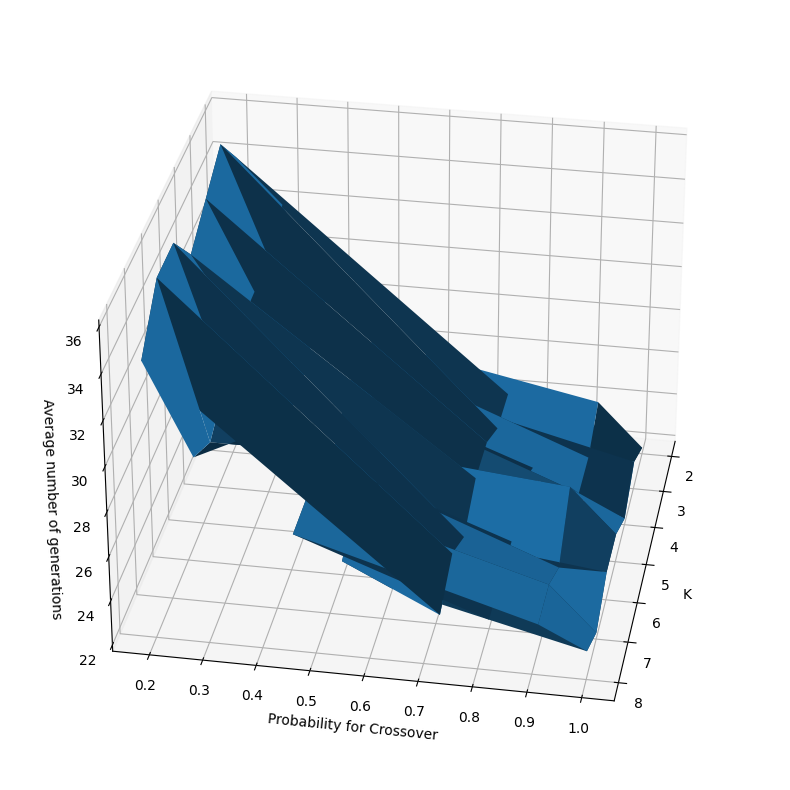

In [257]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data
X = np.array(results_df.columns)  # K parameter values
Y = np.array(results_df.index)  # Y array values
Z = np.random.rand(len(X), len(Y))  # Random result values, replace with your actual data

# Create a meshgrid from X and Y values
X_mesh, Y_mesh = np.meshgrid(X, Y)

# Plot the surface
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
Z = results_df.to_numpy()
ax.plot_surface(X_mesh, Y_mesh, Z)

# Customize the plot
ax.set_xlabel('K')
ax.set_ylabel('Probability for Crossover')
ax.set_zlabel('Average number of generations')

ax.view_init(30, 10)

# Show the plot
plt.show()

In [10]:
import seaborn as snb

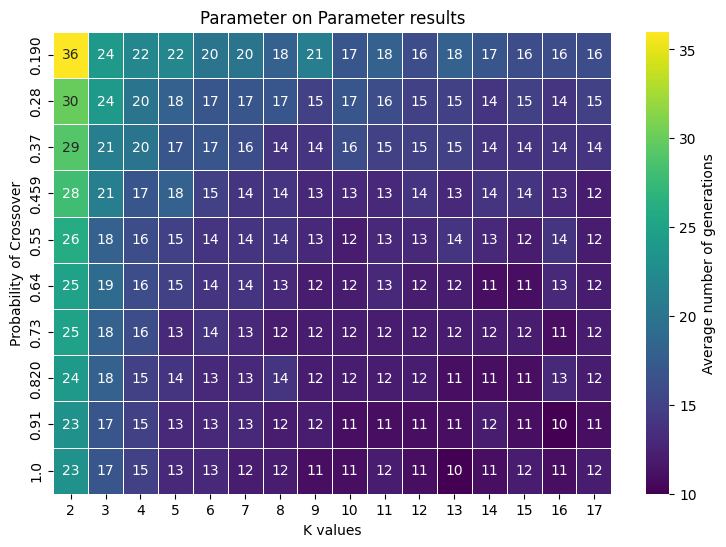

In [11]:
results_df = results_df.sort_index()
results_df.index = results_df.index.astype(str).map(lambda x: x[:5])
results_df.columns = results_df.columns.astype(str)


plt.figure(figsize = (9,6))
snb.heatmap(data=results_df,cmap='viridis', linewidths=0.5, annot=True, cbar_kws={'label': 'Average number of generations'})

plt.title("Parameter on Parameter results")
plt.xlabel('K values')
plt.ylabel("Probability of Crossover")
plt.show()